In [1]:
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import pandas as pd
import shap
from functions import *
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from shap import Explanation
from shap.utils import format_value
from scipy.stats import gaussian_kde
import colormaps as cmaps

In [2]:
%matplotlib inline
plt.ioff()
cmap = cmaps.rdylbu_r

In [3]:
# We need a function that converts the actual variable names into something consistent, short, and readable

def variable_alias(var_name):
	# Define mappings for specific variable name components
	components = {
		'2m_temperature': '2-m T [\u00B0C]',
		'2m_dewpoint_temperature': '2-m D [\u00B0C]',
		'surface_solar_radiation_downwards': 'sol rad [W m$^{-2}$]',
		'total_cloud_cover': 'cloud cover',
		'day_of_week': 'day of week',
		'day_of_year': 'day of year',
		'is_holiday': 'state/national holiday',
		'10m_u_component_of_wind': '10-m u-wind [m s$^{-1}$]',
		'10m_v_component_of_wind': '10-m v-wind [m s$^{-1}$]'
	}
	
	# Check for rolling averages and extract period
	for key in components:
		var_name = var_name.replace(key, components[key])
	
	if 'day' in var_name:
		return f"({var_name})"

	
	elif 'rolling_avg' in var_name:
		parts = var_name.split('_')
		period = parts[2]
		variable = parts[3]
		metric = parts[4]
		name = f'({variable}, {period}, {metric})'
		
	else:
		parts = var_name.split('_')
		variable = parts[0]
		metric = parts[1]
		name = f'({variable}, 1d, {metric})'
		
	return name

In [4]:
# I've modified the original SHAP voilin plot function because it didn't have enough flexibility
# Part of that is to pull these labels out

labels = {
    'MAIN_EFFECT': "SHAP main effect value for\n%s",
    'INTERACTION_VALUE': "SHAP interaction value",
    'INTERACTION_EFFECT': "SHAP interaction value for\n%s and %s",
    'VALUE': "SHAP value (impact on model output)",
    'GLOBAL_VALUE': "mean(|SHAP value|) (average impact on model output magnitude)",
    'VALUE_FOR': "SHAP value for\n%s",
    'PLOT_FOR': "SHAP plot for %s",
    'FEATURE': "Feature %s",
    'FEATURE_VALUE': "Feature value",
    'FEATURE_VALUE_LOW': "Low",
    'FEATURE_VALUE_HIGH': "High",
    'JOINT_VALUE': "Joint SHAP value",
    'MODEL_OUTPUT': "Model output value"
}

In [5]:
# Here is the modified function. Allows for label rotation, more flexible colour options, better colour bar control etc

def violin(shap_values, ax, features=None, feature_names=None, max_display=None, plot_type='violin',
                 color=None, axis_color="#333333", title=None, alpha=1, show=True, sort=True,
                 layered_violin_max_num_bins=20, class_names=None,
                 class_inds=None,
                 color_bar_label=labels["FEATURE_VALUE"],
                 cmap=cmap,
    ):
    """Create a SHAP violin plot, colored by feature values when they are provided.

    Parameters
    ----------
    shap_values : Explanation, or numpy.array
        For single output explanations, this is a matrix of SHAP values (# samples x # features).

    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a ``feature_names`` list as
        shorthand.

    feature_names : list
        Names of the features (length: # features).

    max_display : int
        How many top features to include in the plot (default is 20).

    plot_type : "violin", or "layered_violin".
        What type of summary plot to produce. A "layered_violin" plot shows the
        distribution of the SHAP values of each variable. A "violin" plot is the same,
        except with outliers drawn as scatter points.

    color_bar : bool
        Whether to draw the color bar (legend).

    show : bool
        Whether ``matplotlib.pyplot.show()`` is called before returning.
        Setting this to ``False`` allows the plot
        to be customized further after it has been created.

    plot_size : "auto" (default), float, (float, float), or None
        What size to make the plot. By default, the size is auto-scaled based on the number of
        features that are being displayed. Passing a single float will cause each row to be that
        many inches high. Passing a pair of floats will scale the plot by that
        number of inches. If ``None`` is passed, then the size of the current figure will be left
        unchanged.

    Examples
    --------
    See `violin plot examples <https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/violin.html>`_.

    """
    # support passing an explanation object
    if str(type(shap_values)).endswith("Explanation'>"):
        shap_exp = shap_values
        shap_values = shap_exp.values
        if features is None:
            features = shap_exp.data
        if feature_names is None:
            feature_names = shap_exp.feature_names


    assert len(shap_values.shape) != 1, (
        "Violin summary plots need a matrix of shap_values, not a vector."
    )

    # convert from a DataFrame or other types
    if isinstance(features, pd.DataFrame):
        if feature_names is None:
            feature_names = features.columns
        features = features.values
    elif isinstance(features, list):
        if feature_names is None:
            feature_names = features
        features = None
    elif (features is not None) and len(features.shape) == 1 and feature_names is None:
        feature_names = features
        features = None

    feature_names_raw = feature_names.copy()
    feature_names = [variable_alias(f) for f in feature_names_raw]

    num_features = shap_values.shape[1]

    if features is not None:
        shape_msg = (
            "The shape of the shap_values matrix does not match the shape "
            "of the provided data matrix."
        )
        if num_features - 1 == features.shape[1]:
            shape_msg += (
                " Perhaps the extra column in the shap_values matrix is the "
                "constant offset? If so, just pass shap_values[:,:-1]."
            )
            raise DimensionError(shape_msg)
        if num_features != features.shape[1]:
            raise DimensionError(shape_msg)

    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(num_features)])

    if max_display is None:
        max_display = 20

    if sort:
        # order features by the sum of their effect magnitudes
        feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0))
        feature_order = feature_order[-min(max_display, len(feature_order)):]
    else:
        feature_order = np.flip(np.arange(min(max_display, num_features)), 0)

    row_height = 0.4
   
    ax.axvline(x=0, color="#999999", zorder=-1)

    
    
    num_x_points = 200
    bins = np.linspace(0, features.shape[0], layered_violin_max_num_bins + 1).round(0).astype(
        'int')  # the indices of the feature data corresponding to each bin
    shap_min, shap_max = np.min(shap_values), np.max(shap_values)
    x_points = np.linspace(shap_min, shap_max, num_x_points)

    # loop through each feature and plot:
    for pos, ind in enumerate(feature_order):
        # decide how to handle: if #unique < layered_violin_max_num_bins then split by unique value, otherwise use bins/percentiles.
        # to keep simpler code, in the case of uniques, we just adjust the bins to align with the unique counts.
        feature = features[:, ind]
        unique, counts = np.unique(feature, return_counts=True)
        if unique.shape[0] <= layered_violin_max_num_bins:
            order = np.argsort(unique)
            thesebins = np.cumsum(counts[order])
            thesebins = np.insert(thesebins, 0, 0)
        else:
            thesebins = bins
        nbins = thesebins.shape[0] - 1
        # order the feature data so we can apply percentiling
        order = np.argsort(feature)
        # x axis is located at y0 = pos, with pos being there for offset
        # y0 = np.ones(num_x_points) * pos
        # calculate kdes:
        ys = np.zeros((nbins, num_x_points))
        for i in range(nbins):
            # get shap values in this bin:
            shaps = shap_values[order[thesebins[i]:thesebins[i + 1]], ind]
            # if there's only one element, then we can't
            if shaps.shape[0] == 1:
                warnings.warn(
                    "not enough data in bin #%d for feature %s, so it'll be ignored. Try increasing the number of records to plot."
                    % (i, feature_names[ind]))
                # to ignore it, just set it to the previous y-values (so the area between them will be zero). Not ys is already 0, so there's
                # nothing to do if i == 0
                if i > 0:
                    ys[i, :] = ys[i - 1, :]
                continue
            # save kde of them: note that we add a tiny bit of gaussian noise to avoid singular matrix errors
            ys[i, :] = gaussian_kde(shaps + np.random.normal(loc=0, scale=0.001, size=shaps.shape[0]))(x_points)
            # scale it up so that the 'size' of each y represents the size of the bin. For continuous data this will
            # do nothing, but when we've gone with the unique option, this will matter - e.g. if 99% are male and 1%
            # female, we want the 1% to appear a lot smaller.
            size = thesebins[i + 1] - thesebins[i]
            bin_size_if_even = features.shape[0] / nbins
            relative_bin_size = size / bin_size_if_even
            ys[i, :] *= relative_bin_size
        # now plot 'em. We don't plot the individual strips, as this can leave whitespace between them.
        # instead, we plot the full kde, then remove outer strip and plot over it, etc., to ensure no
        # whitespace
        ys = np.cumsum(ys, axis=0)
        width = 0.8
        scale = ys.max() * 2 / width  # 2 is here as we plot both sides of x axis
        for i in range(nbins - 1, -1, -1):
            y = ys[i, :] / scale
            c = cmap(i / (nbins - 1)) 
            ax.fill_between(x_points, pos - y, pos + y, facecolor=c, edgecolor="face")
        
        ax.set_xlim(shap_min, shap_max)

    import matplotlib.cm as cm
    m = cm.ScalarMappable(cmap=cmap)



    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('none')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(color=axis_color, labelcolor=axis_color)
    ax.set_yticks(range(len(feature_order)), [feature_names[i] for i in feature_order], fontsize=10)
    ax.tick_params(axis='y', labelrotation=30)
    #ax.tick_params('y', length=20, width=0.5, which='major')
    ax.tick_params('x', labelsize=10)
    ax.set_ylim(-1, len(feature_order))
    #ax.set_xlabel(labels['VALUE'], fontsize=13)
    
    return m

In [6]:
# Related to the modified violinplot function, which is dependent on this function.
# No changes from the original SHAP code here

def _trim_crange(values, nan_mask):
    """Trim the color range, but prevent the color range from collapsing."""
    # Get vmin and vmax as 5. and 95. percentiles
    vmin = np.nanpercentile(values, 5)
    vmax = np.nanpercentile(values, 95)
    if vmin == vmax:  # if percentile range is equal, take 1./99. perc.
        vmin = np.nanpercentile(values, 1)
        vmax = np.nanpercentile(values, 99)
        if vmin == vmax:  # if still equal, use min/max
            vmin = np.min(values)
            vmax = np.max(values)

    if vmin > vmax: # fixes rare numerical precision issues
        vmin = vmax

    # Get color values depending on value range
    cvals = values[np.invert(nan_mask)].astype(np.float64)
    cvals_imp = cvals.copy()
    cvals_imp[np.isnan(cvals)] = (vmin + vmax) / 2.0
    cvals[cvals_imp > vmax] = vmax
    cvals[cvals_imp < vmin] = vmin

    return vmin, vmax, cvals

In [7]:
def shorten_text(text, length_limit):
    if len(text) > length_limit:
        return text[:length_limit - 3] + "..."
    else:
        return text

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Load hyperparameters
hyperparameters_df = pd.read_csv("outputs/best_hyperparameters.csv")
hyperparameters_dict = hyperparameters_df.set_index('state').T.to_dict()

feature_names = feature_names_full
print(feature_names)
feature_names.remove("day_of_year")

states = ['Kerala', 'Odisha', 'NCT_of_Delhi', 'Jammu_and_Kashmir']

['10m_u_component_of_wind_mean', '10m_v_component_of_wind_mean', '2m_temperature_min', '2m_temperature_mean', '2m_temperature_max', '2m_dewpoint_temperature_min', '2m_dewpoint_temperature_mean', '2m_dewpoint_temperature_max', 'surface_solar_radiation_downwards_mean', 'surface_solar_radiation_downwards_max', 'total_cloud_cover_mean', 'total_cloud_cover_max', 'is_holiday', 'day_of_week', 'day_of_year', 'rolling_avg_30d_2m_temperature_mean', 'rolling_avg_7d_2m_temperature_mean', 'rolling_avg_30d_2m_dewpoint_temperature_mean', 'rolling_avg_7d_2m_dewpoint_temperature_mean', 'rolling_avg_30d_surface_solar_radiation_downwards_mean', 'rolling_avg_7d_surface_solar_radiation_downwards_mean', 'rolling_avg_30d_total_cloud_cover_mean', 'rolling_avg_7d_total_cloud_cover_mean']


In [9]:

for ax, state in zip(axes.ravel(), states):
	subdiv = states_subdiv_mapping[state]

	df, df_energy = load_data(state)
	df = process_data(df, df_energy, subdiv)
	df = df[feature_names + ['date', 'energy_met_MU']]
	df = df.dropna()

	df = adjust_variables(df)

	ax_name = state.replace("_", " ").replace("and ", "& ")

	X = df[feature_names]
	y = df['energy_met_MU']

	best_params = hyperparameters_dict[state]

	xg_reg, X_test, y_test, preds = train_model(X, y, df, best_params)#, year=2019)
	r_value, n_trees = evaluate_model(xg_reg, X_test, y_test, preds)

	explainer = shap.Explainer(xg_reg)
	shap_values = explainer(X)

	predicted_demand = xg_reg.predict(X).squeeze()

	m = violin(shap_values, ax, X, show=False, max_display=8)

	ax.set_title(ax_name)

State: 
RMSE: 4.990395987563681
SN: 0.4308475007142255
LinregressResult(slope=0.7805548618627238, intercept=0.001100923673679921, rvalue=0.903277755475274, pvalue=4.062562204012687e-199, stderr=0.016014522430383742, intercept_stderr=0.18550686004519135)
--------------------------------------------------
State: 
RMSE: 10.999877607556728
SN: 0.5124919243937368
LinregressResult(slope=0.6881977564902776, intercept=-0.5123862032351898, rvalue=0.8611581628316793, pvalue=1.2565073086865995e-159, stderr=0.01754687376114501, intercept_stderr=0.3766478287818484)
--------------------------------------------------
State: 
RMSE: 5.9678475851732395
SN: 0.19750192728482777
LinregressResult(slope=0.9595370308283123, intercept=0.16124827041599055, rvalue=0.9803415350155276, pvalue=0.0, stderr=0.008341550658683054, intercept_stderr=0.25287616381931494)
--------------------------------------------------
State: 
RMSE: 3.0969228368298487
SN: 0.6203333478667239
LinregressResult(slope=0.5796470099419323, int

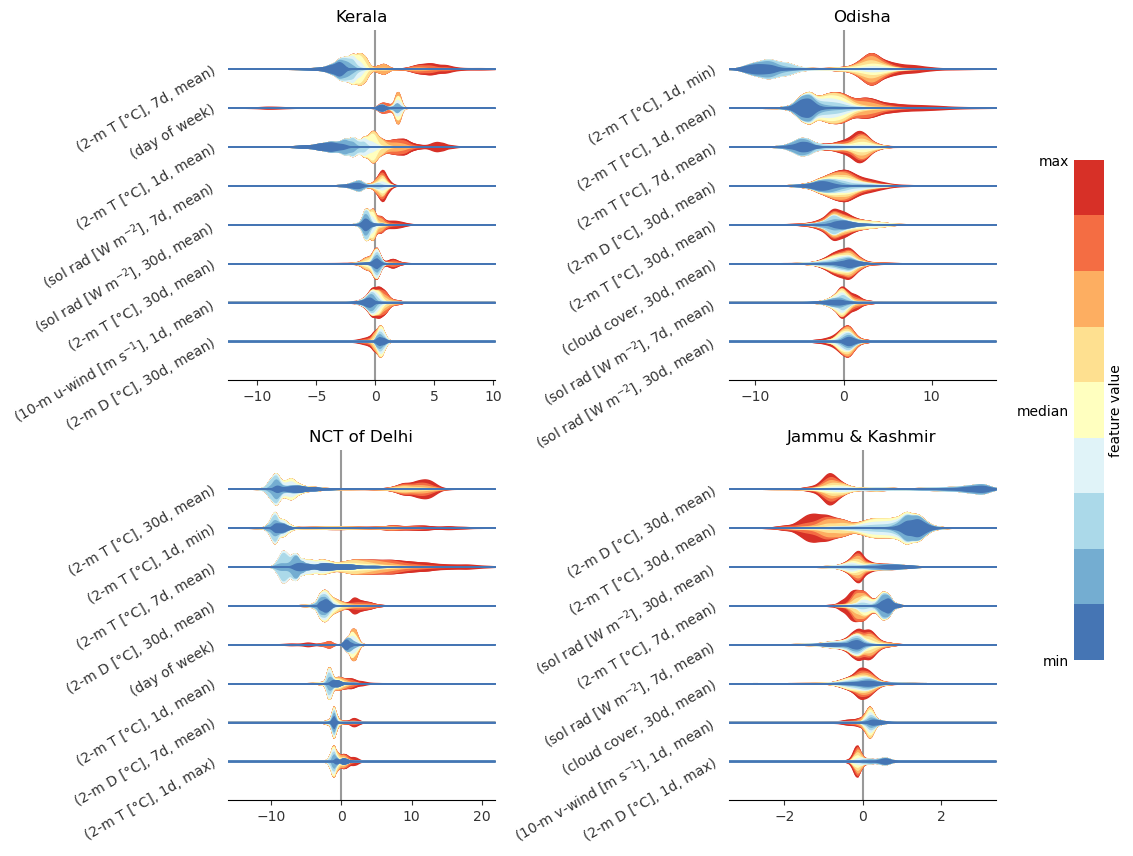

In [10]:
cax = fig.add_axes([0.915, 0.25, 0.025, 0.5])

cb = plt.colorbar(m, cax=cax,)
cb.set_ticks([0, 0.5, 1])
cb.set_ticklabels(['min', 'median', 'max'])
cax.yaxis.set_ticks_position('left')
cb.set_label('feature value')
cb.ax.tick_params(length=0)
#cb.set_alpha(1)
cb.outline.set_visible(False)


fig.subplots_adjust(left=0.21, right=0.85, wspace=0.875)

plt.show()
